This Notebook aims to combine all necessary steps for each model of the nonlinear ML methods.

In [1]:
# first import the libraries
import pandas as pd
import numpy as np
from darts import TimeSeries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from darts.models import LinearRegressionModel, RegressionModel, RandomForest, RegressionEnsembleModel
from sklearn import cross_decomposition
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, NuSVR
from sklearn.neural_network import MLPRegressor
from darts.metrics import mape, r2_score, mae, mse
import sklearn
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting, EfficientFrontier

import warnings

In [2]:
# Filter out the FutureWarning message
warnings.filterwarnings("ignore", category=(FutureWarning))
warnings.filterwarnings("ignore", category=(UserWarning))

In [3]:
# load the data, use Darts TimeSeries
ts = TimeSeries.from_csv('data/price_data_filtered.csv', parse_dates=True, index_col=0)

In [4]:
# compute monthly returns using pandas pct_change
returns = ts.pd_dataframe().pct_change().dropna()

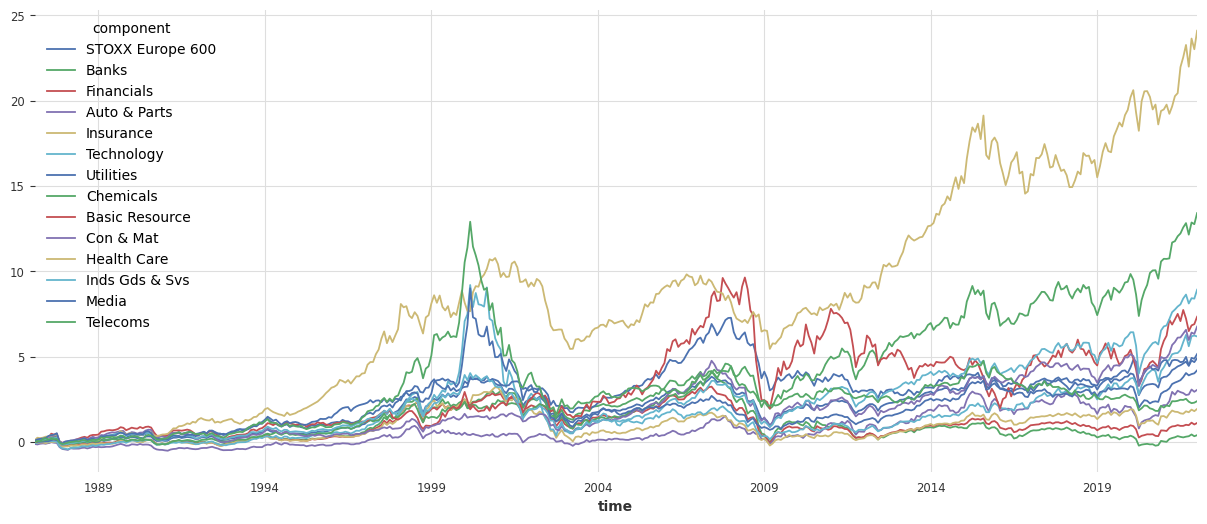

In [5]:
#from io import BytesIO
# compute the cumulative monthly returns
cum_returns = (1 + returns).cumprod() - 1

cum_returns_portfolio = cum_returns

# plot the cumulative returns
fig, ax = plt.subplots(figsize=(15, 6))
cum_returns.plot(ax=ax);

In [6]:
# to use the Darts models, we need to convert the data to a Darts TimeSeries
cum_returns = TimeSeries.from_dataframe(df = cum_returns,time_col= 0, fill_missing_dates=True)

In [7]:
# split the data into training and test set, use 80% for training
train, test = cum_returns.split_after(0.8)

In [8]:
# show length of train and test set
print('Length of train set: {}, length of test set: {}.'.format(len(train), len(test)))

Length of train set: 336, length of test set: 84.


## Benchmark Portfolios

Our main benchmark is the STOXX Europe 600 Index. Furthermore, we expand the benchmarks by computing the equal weighted portfolio and portfolio based on historical averages.

### Equal Weighted Portfolio

In [9]:
# create a list of the column names
col_list = list(cum_returns.columns)[1:]

# create weights
weights_ew = 1/len(col_list)

# print single weight and the sum of all weights
print('The weight for each stock is: ' + str(weights_ew))
print('The sum of all weights is: ' + str(weights_ew * 13))

# create a new column in cum_returns for the equal weighted portfolio
cum_returns_portfolio['equal_weighted'] = cum_returns_portfolio[col_list].mul(weights_ew).sum(axis=1)

# create a new variable called portfolio_returns with same structure as cum_returns
portfolio_returns = cum_returns_portfolio.copy()
# delete all columns except for the equal_weighted column
portfolio_returns.drop(cum_returns_portfolio.columns.difference(['equal_weighted']), 1, inplace=True)
portfolio_returns.tail()

# delete equal weighted column from cum_returns
cum_returns_portfolio.drop('equal_weighted', axis=1, inplace=True)

The weight for each stock is: 0.07692307692307693
The sum of all weights is: 1.0


### Portfolio based on Historical Average

In [10]:
# Calculate average daily returns for each stock and exlude the first column
avg_returns = cum_returns_portfolio.mean()[1:]

# Calculate weights based on average daily returns
weights_ha = avg_returns / avg_returns.sum()

# Calculate portfolio returns
ha_returns = (cum_returns_portfolio * weights_ha).sum(axis=1)

# Add portfolio_returns as a new column in cum_returns
portfolio_returns['historical_average'] = ha_returns

# show the last 5 rows of portfolio_returns of historical average portfolio
portfolio_returns.tail(1)

component,equal_weighted,historical_average
time,,
2022-01-01,6.544394,10.913366


In [11]:
# print single weight and the sum of all weights for historical average portfolio
print('The weight for each stock is: ' + str(weights_ha))
print('The sum of all weights is: ' + str(weights_ha.sum()))

The weight for each stock is: component
Banks             0.033024
Financials        0.030685
Auto & Parts      0.021829
Insurance         0.027747
Technology        0.050778
Utilities         0.085845
Chemicals         0.108597
Basic Resource    0.099537
Con & Mat         0.061754
Health Care       0.258600
Inds Gds & Svs    0.076979
Media             0.063096
Telecoms          0.081530
dtype: float64
The sum of all weights is: 1.0


## Nonlinear Machine Learning Methods

### Random Forest

In [12]:
# random forest regression model with 1 lag
randomforest_model_1 = RegressionModel(lags=1, model=sklearn.ensemble.RandomForestRegressor(n_estimators=147, max_depth=300, random_state=0))
randomforest_model_1.fit(train)
randomforest_forecast_1 = randomforest_model_1.predict(len(test))

In [13]:
# first random forest model with 1 lag
hf1_random_forest = randomforest_model_1.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

  0%|          | 0/127 [00:00<?, ?it/s]

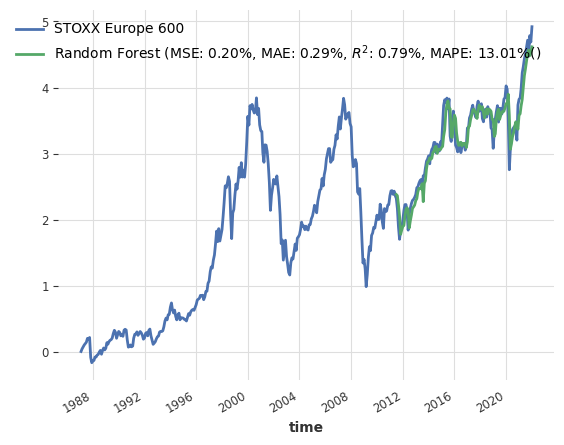

In [14]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_random_forest['STOXX Europe 600'].plot(label='Random Forest (MSE: {:.2f}%, MAE: {:.2f}%, $R^2$: {:.2f}%, MAPE: {:.2f}%()'.format(mse(hf1_random_forest, cum_returns), mae(hf1_random_forest, cum_returns), r2_score(hf1_random_forest, cum_returns), mape(hf1_random_forest, cum_returns)))

#### Portfolio

In [15]:
# change the type of the random forest forecast to a dataframe
randomforest_forecast_1 = randomforest_forecast_1.pd_dataframe()

In [16]:
# perform mean-variance optimization on the random forest forecast
mu_randomforest_1 = expected_returns.mean_historical_return(randomforest_forecast_1)
S_randomforest_1 = risk_models.sample_cov(randomforest_forecast_1)

In [17]:
# optimize for maximal Sharpe ratio
ef_randomforest_1 = EfficientFrontier(mu_randomforest_1, S_randomforest_1)
ef_randomforest_1.add_constraint(lambda w: w[0] == 0)
weights_randomforest_1 = ef_randomforest_1.max_sharpe(risk_free_rate=0.02)

In [18]:
# print the weights in a table and round them to 4 decimals
print('Weights for Linear regression with 1 lag: ' + str(np.round(pd.Series(weights_randomforest_1), 3)))

Weights for Linear regression with 1 lag: STOXX Europe 600    0.0
Banks              -0.0
Financials         -0.0
Auto & Parts        0.0
Insurance           0.0
Technology          0.0
Utilities           0.0
Chemicals           0.0
Basic Resource     -0.0
Con & Mat           0.0
Health Care         1.0
Inds Gds & Svs      0.0
Media               0.0
Telecoms           -0.0
dtype: float64


In [19]:
# compute the returns of the random forest portfolio
rf_returns_1 = (cum_returns_portfolio * weights_randomforest_1).sum(axis=1)

portfolio_returns['random_forest_1'] = rf_returns_1

In [20]:
# show the last value of each portfolio and round it to 2 decimals
print('The last value of the random forest portfolio is: ' + str(round(portfolio_returns['random_forest_1'].iloc[-1], 2)) + '%')

The last value of the random forest portfolio is: 24.1%


### Gradient Boosting Regressor

In [21]:
# gradient boosting regression model with 1 lag
gradient_boosting_model_1 = RegressionModel(lags=1, model=sklearn.ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=31, learning_rate=0.3, random_state=0))
gradient_boosting_model_1.fit(train)
gradient_boosting_forecast_1 = gradient_boosting_model_1.predict(len(test))

In [22]:
# first gradient boosting model with 1 lag
hf1_gradient_boosting = gradient_boosting_model_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

  0%|          | 0/169 [00:00<?, ?it/s]

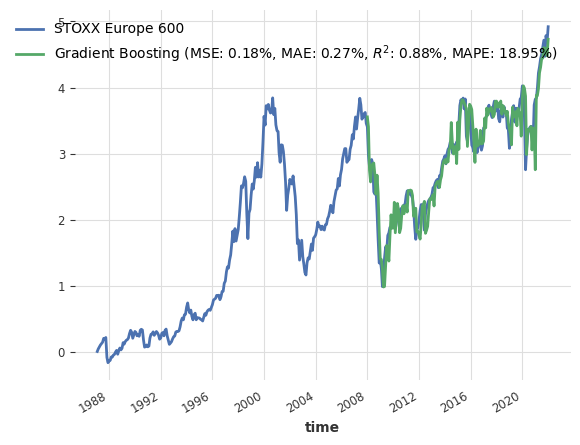

In [23]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_gradient_boosting['STOXX Europe 600'].plot(label='Gradient Boosting (MSE: {:.2f}%, MAE: {:.2f}%, $R^2$: {:.2f}%, MAPE: {:.2f}%)'.format(mse(hf1_gradient_boosting, cum_returns), mae(hf1_gradient_boosting, cum_returns), r2_score(hf1_gradient_boosting, cum_returns), mape(hf1_gradient_boosting, cum_returns)))

#### Portfolio

In [24]:
# change the type of the gradient boosting forecast to a dataframe
gradient_boosting_forecast_1 = gradient_boosting_forecast_1.pd_dataframe()

In [25]:
# perform mean-variance optimization on the gradient boosting forecast
mu_gb_1 = expected_returns.mean_historical_return(gradient_boosting_forecast_1)
S_gb_1 = risk_models.sample_cov(gradient_boosting_forecast_1)

In [26]:
# optimize for maximal Sharpe ratio
ef_gb_1 = EfficientFrontier(mu_gb_1, S_gb_1)
ef_gb_1.add_constraint(lambda w: w[0] == 0)
weights_gb_1 = ef_gb_1.max_sharpe()

In [27]:
# print the weights in a table and round them to 4 decimals
print('Weights for Linear regression with 1 lag: ' + str(np.round(pd.Series(weights_gb_1), 3)))

Weights for Linear regression with 1 lag: STOXX Europe 600   -0.0
Banks              -0.0
Financials          0.0
Auto & Parts        0.0
Insurance          -0.0
Technology         -0.0
Utilities           0.0
Chemicals          -0.0
Basic Resource     -0.0
Con & Mat          -0.0
Health Care         0.0
Inds Gds & Svs      1.0
Media              -0.0
Telecoms           -0.0
dtype: float64


In [28]:
# compute the returns of the gradient boosting portfolio
gb_returns_1 = (cum_returns_portfolio * weights_gb_1).sum(axis=1)

# add the gb returns to the dataframe
portfolio_returns['gradient_boosting_1'] = gb_returns_1

In [29]:
# show the last value of each portfolio in percentage and round to 2 decimals
print('The last value of the gradient boosting portfolio with 1 lag is: ' + str(round(portfolio_returns['gradient_boosting_1'].iloc[-1], 2)) + '%')

The last value of the gradient boosting portfolio with 1 lag is: 8.93%


### AdaBoost

In [30]:
# first ada boosting model with 1 lag
ada_boosting_1 = RegressionModel(lags= 1, model=sklearn.ensemble.AdaBoostRegressor(n_estimators=50, learning_rate=0.3, random_state=0, loss='exponential'))
ada_boosting_1.fit(train)
ada_boosting_forecast_1 = ada_boosting_1.predict(len(test))

In [31]:
# first ada boosting model with 1 lag
hf1_ada_boosting = ada_boosting_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

  0%|          | 0/169 [00:00<?, ?it/s]

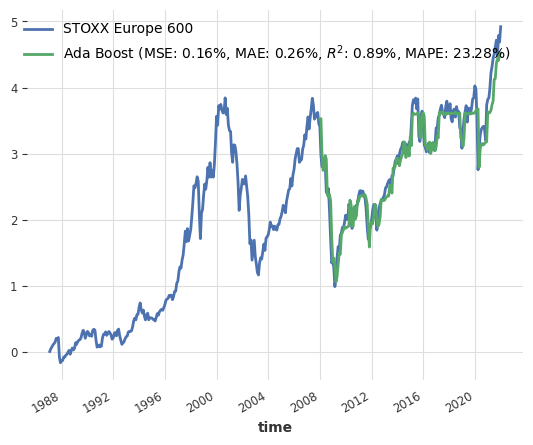

In [32]:
# compute the historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
# hf1 with mape, mse and r2
hf1_ada_boosting['STOXX Europe 600'].plot(label='Ada Boost (MSE: {:.2f}%, MAE: {:.2f}%, $R^2$: {:.2f}%, MAPE: {:.2f}%)'.format(mse(hf1_ada_boosting, cum_returns), mae(hf1_ada_boosting, cum_returns), r2_score(hf1_ada_boosting, cum_returns),  mape(hf1_ada_boosting, cum_returns)))
plt.legend()
plt.show();

#### Portfolio

In [33]:
# change the type of the ada boosting forecast to a dataframe
ada_boosting_forecast = ada_boosting_forecast_1.pd_dataframe()

In [34]:
# perform mean-variance optimization on the ada boosting forecast
mu_ada_boosting = expected_returns.mean_historical_return(ada_boosting_forecast)
S_ada_boosting = risk_models.sample_cov(ada_boosting_forecast)

In [35]:
# optimize for maximal Sharpe ratio
ef_ada_boosting = EfficientFrontier(mu_ada_boosting, S_ada_boosting)
ef_ada_boosting.add_constraint(lambda w: w[0] == 0)
weights_ada_boosting = ef_ada_boosting.max_sharpe()

In [36]:
# print the weights in a table and round them to 4 decimals
print('Weights for Linear regression with 1 lag: ' + str(np.round(pd.Series(weights_ada_boosting), 3)))

Weights for Linear regression with 1 lag: STOXX Europe 600   -0.0
Banks               0.0
Financials          0.0
Auto & Parts        0.0
Insurance           0.0
Technology          0.0
Utilities           0.0
Chemicals          -0.0
Basic Resource      1.0
Con & Mat          -0.0
Health Care        -0.0
Inds Gds & Svs     -0.0
Media               0.0
Telecoms           -0.0
dtype: float64


In [37]:
# compute the returns of the ada boosting portfolio
ada_boosting_returns = (cum_returns_portfolio * weights_ada_boosting).sum(axis=1)

# add the ada boosting returns to the dataframe
portfolio_returns['ada_boosting'] = ada_boosting_returns

In [38]:
# show the last value of each portfolio and round it to 2 decimals
print('Last value of the ada boosting portfolio: ' + str(round(portfolio_returns['ada_boosting'].iloc[-1], 2)) + '%')

Last value of the ada boosting portfolio: 7.35%


### Extremely Randomized Trees

In [39]:
# extra trees model with 1 lag
extra_trees_1 = RegressionModel(lags= 1, model=ExtraTreesRegressor(n_estimators=62, max_depth= 5, min_samples_split= 15, random_state=0))
extra_trees_1.fit(train)
extra_trees_forecast_1 = extra_trees_1.predict(len(test))

In [40]:
# historical forecasts of the extra trees model with 1 lag
hf1_extra_trees = extra_trees_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

  0%|          | 0/169 [00:00<?, ?it/s]

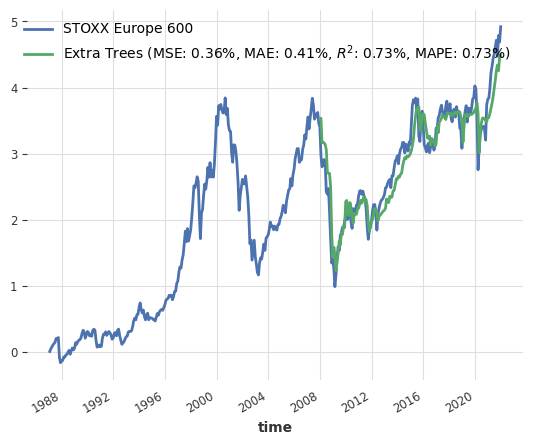

In [41]:
# compute the historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
# hf1 with mape, mse and r2
hf1_extra_trees['STOXX Europe 600'].plot(label='Extra Trees (MSE: {:.2f}%, MAE: {:.2f}%, $R^2$: {:.2f}%, MAPE: {:.2f}%)'.format(mse(hf1_extra_trees, cum_returns), mae(hf1_extra_trees, cum_returns), r2_score(hf1_extra_trees, cum_returns), r2_score(hf1_extra_trees, cum_returns)))
plt.legend()
plt.show();

#### Portfolio

In [42]:
# change the type of the extra trees forecast to a dataframe
extra_trees_forecast = extra_trees_forecast_1.pd_dataframe()

In [43]:
# perform mean-variance optimization on the extra trees forecast
mu_extra_trees = expected_returns.mean_historical_return(extra_trees_forecast)
S_extra_trees = risk_models.sample_cov(extra_trees_forecast)

In [44]:
# optimize for maximal Sharpe ratio
ef_extra_trees = EfficientFrontier(mu_extra_trees, S_extra_trees)
ef_extra_trees.add_constraint(lambda w: w[0] == 0)
weights_extra_trees = ef_extra_trees.max_sharpe()

In [45]:
# print the weights in a table and round them to 4 decimals
print('Weights for Linear regression with 1 lag: ' + str(np.round(pd.Series(weights_extra_trees), 3)))

Weights for Linear regression with 1 lag: STOXX Europe 600   -0.0
Banks               0.0
Financials          0.0
Auto & Parts       -0.0
Insurance           0.0
Technology          0.0
Utilities           0.0
Chemicals           1.0
Basic Resource     -0.0
Con & Mat          -0.0
Health Care        -0.0
Inds Gds & Svs     -0.0
Media               0.0
Telecoms            0.0
dtype: float64


In [46]:
# compute the returns of the extra trees portfolio
extra_trees_returns = (cum_returns_portfolio * weights_extra_trees).sum(axis=1)

# add the extra trees returns to the dataframe
portfolio_returns['extra_trees'] = extra_trees_returns

In [47]:
# show the last value of extra tree portfolio and round it to 2 decimals
print('Last value of the extra trees portfolio: ' + str(round(portfolio_returns['extra_trees'].iloc[-1], 2)) + '%')

Last value of the extra trees portfolio: 13.42%


###  $\varepsilon$ Support Vector Regressor

In [48]:
# epsilon svm model with 1 lag
epsilon_svm_1 = RegressionModel(lags= 1, model=sklearn.svm.SVR(kernel='rbf', C=2, gamma=0.094, epsilon=0.069))
epsilon_svm_1.fit(train)
epsilon_svm_forecast_1 = epsilon_svm_1.predict(len(test))

  0%|          | 0/169 [00:00<?, ?it/s]

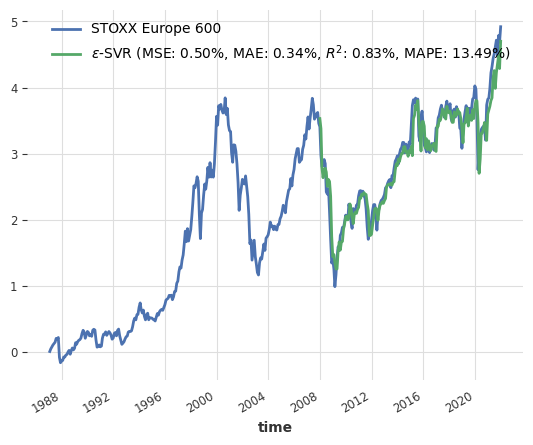

In [78]:
# historical forecasts of the epsilon svm model with 1 lag
hf1_epsilon_svm = epsilon_svm_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# compute the historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
# hf1 with mape, mse and r2
hf1_epsilon_svm['STOXX Europe 600'].plot(label=r'$\varepsilon$-SVR (MSE: {:.2f}%, MAE: {:.2f}%, $R^2$: {:.2f}%, MAPE: {:.2f}%)'.format(mse(hf1_epsilon_svm, cum_returns), mae(hf1_epsilon_svm, cum_returns), r2_score(hf1_epsilon_svm, cum_returns), mape(hf1_epsilon_svm, cum_returns)))
plt.legend()
plt.show();

#### Portfolio

In [54]:
# change the type of the epsilon svm forecast to a dataframe
epsilon_svm_forecast = epsilon_svm_forecast_1.pd_dataframe()

In [55]:
# perform mean-variance optimization on the epsilon svm forecast
mu_epsilon_svm = expected_returns.mean_historical_return(epsilon_svm_forecast)
S_epsilon_svm = risk_models.sample_cov(epsilon_svm_forecast)

In [56]:
# optimize for maximal Sharpe ratio
ef_epsilon_svm = EfficientFrontier(mu_epsilon_svm, S_epsilon_svm)
ef_epsilon_svm.add_constraint(lambda w: w[0] == 0)
weights_epsilon_svm = ef_epsilon_svm.max_sharpe(risk_free_rate=0.02)

In [57]:
# print the weights in a table and round them to 4 decimals
print('Weights for Linear regression with 1 lag: ' + str(np.round(pd.Series(weights_epsilon_svm), 3)))

Weights for Linear regression with 1 lag: STOXX Europe 600    0.000
Banks               0.000
Financials          0.000
Auto & Parts        0.000
Insurance           0.000
Technology          0.000
Utilities           0.000
Chemicals           0.000
Basic Resource      0.206
Con & Mat           0.000
Health Care         0.794
Inds Gds & Svs      0.000
Media               0.000
Telecoms            0.000
dtype: float64


In [58]:
# compute the returns of the epsilon svm portfolio
epsilon_svm_returns = (cum_returns_portfolio * weights_epsilon_svm).sum(axis=1)

# add the epsilon svm returns to the dataframe
portfolio_returns['epsilon_svm'] = epsilon_svm_returns

In [59]:
# show the last value of epsilon svm portfolio and round it to 2 decimals
print('Last value of the epsilon svm portfolio: ' + str(round(portfolio_returns['epsilon_svm'].iloc[-1], 2)) + '%')

Last value of the epsilon svm portfolio: 20.64%


### $\nu$ Support Vector Regressor

In [60]:
# nu svm model with 1 lag
nu_svm_1 = RegressionModel(lags= 1, model=sklearn.svm.NuSVR(kernel='rbf', C=13, gamma=0.04, nu=0.55))
nu_svm_1.fit(train)
nu_svm_forecast_1 = nu_svm_1.predict(len(test))

  0%|          | 0/169 [00:00<?, ?it/s]

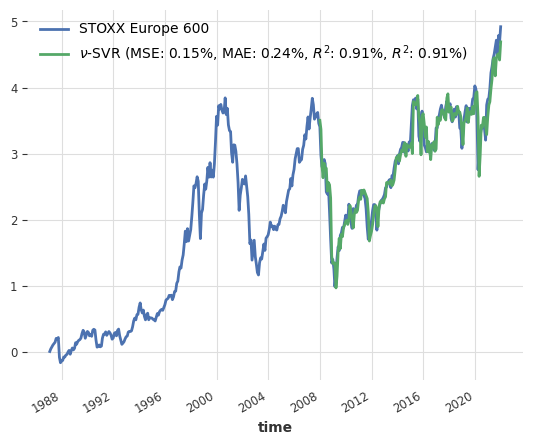

In [79]:
# historical forecasts of the nu svm model with 1 lag
hf1_nu_svm = nu_svm_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# compute the historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
# hf1 with mape, mse and r2
hf1_nu_svm['STOXX Europe 600'].plot(label=r'$\nu$-SVR (MSE: {:.2f}%, MAE: {:.2f}%, $R^2$: {:.2f}%, $R^2$: {:.2f}%)'.format(mse(hf1_nu_svm, cum_returns), mae(hf1_nu_svm, cum_returns), r2_score(hf1_nu_svm, cum_returns), r2_score(hf1_nu_svm, cum_returns)))
plt.legend()
plt.show();

#### Portfolio

In [62]:
# change the type of the nu svm forecast to a dataframe
nu_svm_forecast = nu_svm_forecast_1.pd_dataframe()

In [63]:
# perform mean-variance optimization on the nu svm forecast
mu_nu_svm = expected_returns.mean_historical_return(nu_svm_forecast)
S_nu_svm = risk_models.sample_cov(nu_svm_forecast)

In [64]:
# optimize for maximal Sharpe ratio
ef_nu_svm = EfficientFrontier(mu_nu_svm, S_nu_svm)
ef_nu_svm.add_constraint(lambda w: w[0] == 0)
weights_nu_svm = ef_nu_svm.max_sharpe(risk_free_rate=0.02)

In [65]:
# print the weights in a table and round them to 4 decimals
print('Weights for Linear regression with 1 lag: ' + str(np.round(pd.Series(weights_nu_svm), 3)))

Weights for Linear regression with 1 lag: STOXX Europe 600    0.000
Banks               0.000
Financials          0.000
Auto & Parts        0.000
Insurance           0.000
Technology          0.000
Utilities           0.000
Chemicals           0.000
Basic Resource      0.363
Con & Mat           0.000
Health Care         0.637
Inds Gds & Svs      0.000
Media               0.000
Telecoms            0.000
dtype: float64


In [66]:
# compute the returns of the nu svm portfolio
nu_svm_returns = (cum_returns_portfolio * weights_nu_svm).sum(axis=1)

# add the nu svm returns to the dataframe
portfolio_returns['nu_svm'] = nu_svm_returns

In [67]:
# show the last value of nu svm portfolio and round it to 2 decimals
print('Last value of the nu svm portfolio: ' + str(round(portfolio_returns['nu_svm'].iloc[-1], 2)) + '%')

Last value of the nu svm portfolio: 18.02%


### Multilayer perceptron with 3 hidden layers

In [68]:
# mlp1 model with 1 lag
mlp1_3 = RegressionModel(lags= 1, model=sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(40, 20, 20), max_iter=200, activation='relu', random_state= 0))
mlp1_3.fit(train)
mlp1_forecast_1 = mlp1_3.predict(len(test))

  0%|          | 0/169 [00:00<?, ?it/s]

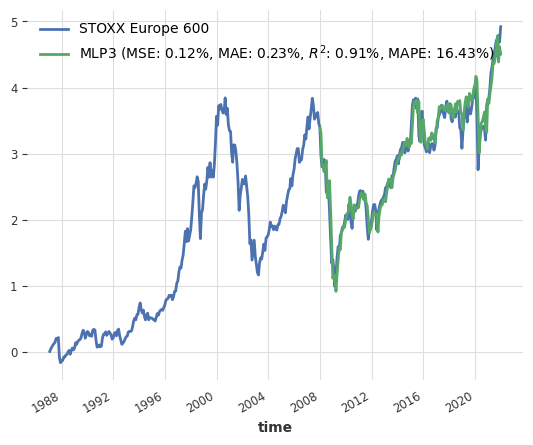

In [69]:
# historical forecasts of the mlp1 model with 1 lag
hf1_mlp3 = mlp1_3.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# compute the historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
# hf1 with mape, mse and r2
hf1_mlp3['STOXX Europe 600'].plot(label='MLP3 (MSE: {:.2f}%, MAE: {:.2f}%, $R^2$: {:.2f}%, MAPE: {:.2f}%)'.format(mse(hf1_mlp3, cum_returns), mae(hf1_mlp3, cum_returns), r2_score(hf1_mlp3, cum_returns), mape(hf1_mlp3, cum_returns)))
plt.legend()
plt.show();

#### Portfolio

In [70]:
# change the type of the mlp1 forecast to a dataframe
mlp3_forecast = mlp1_forecast_1.pd_dataframe()

In [71]:
# perform mean-variance optimization on the mlp1 forecast
mu_mlp3 = expected_returns.mean_historical_return(mlp3_forecast)
S_mlp3 = risk_models.sample_cov(mlp3_forecast)

In [72]:
# optimize for maximal Sharpe ratio
ef_mlp3 = EfficientFrontier(mu_mlp3, S_mlp3)
ef_mlp3.add_constraint(lambda w: w[0] == 0)
weights_mlp3 = ef_mlp3.max_sharpe(risk_free_rate=0.02)

In [73]:
# print the weights in a table and round them to 4 decimals
print('Weights for Linear regression with 1 lag: ' + str(np.round(pd.Series(weights_mlp3), 3)))

Weights for Linear regression with 1 lag: STOXX Europe 600   -0.000
Banks              -0.000
Financials         -0.000
Auto & Parts        0.000
Insurance           0.000
Technology         -0.000
Utilities           0.128
Chemicals           0.137
Basic Resource     -0.000
Con & Mat           0.000
Health Care         0.735
Inds Gds & Svs     -0.000
Media               0.000
Telecoms           -0.000
dtype: float64


In [74]:
# compute the returns of the mlp1 portfolio
mlp3_returns = (cum_returns_portfolio * weights_mlp3).sum(axis=1)

# add the mlp3 returns to the dataframe
portfolio_returns['MLP3'] = mlp3_returns

In [75]:
# show the last value of mlp1 portfolio and round it to 2 decimals
print('Last value of the mlp1 portfolio: ' + str(round(portfolio_returns['MLP3'].iloc[-1], 2)) + '%')

Last value of the mlp1 portfolio: 20.21%


# Analysis Nonlinear Machine Learning

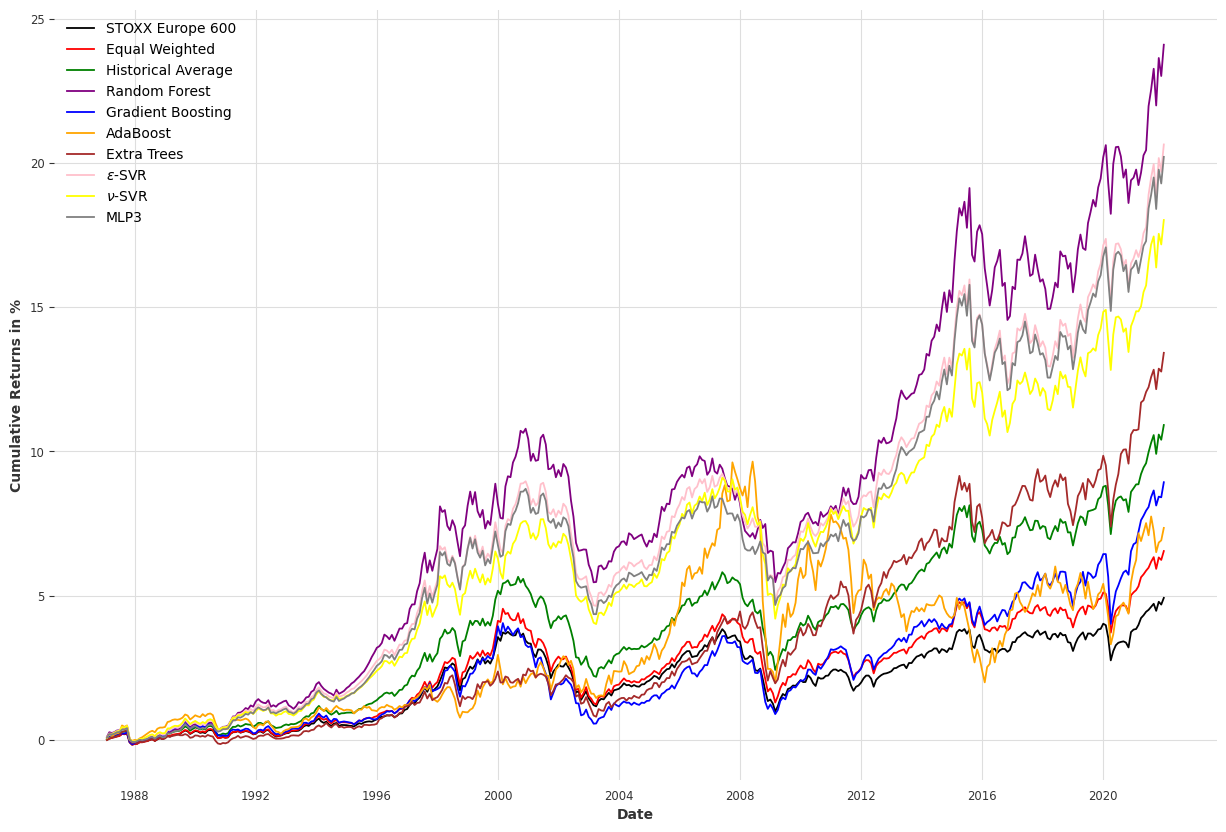

In [80]:
# plot all the cumulative returns
plt.figure(figsize=(15, 10))

plt.plot(cum_returns_portfolio['STOXX Europe 600'], color= 'black', label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], color= 'red', label='Equal Weighted')
plt.plot(portfolio_returns['historical_average'], color= 'green', label='Historical Average')
plt.plot(portfolio_returns['random_forest_1'], label='Random Forest', color='purple')
plt.plot(portfolio_returns['gradient_boosting_1'], label='Gradient Boosting', color='blue')
plt.plot(portfolio_returns['ada_boosting'], label='AdaBoost', color='orange')
plt.plot(portfolio_returns['extra_trees'], label='Extra Trees', color='brown')
plt.plot(portfolio_returns['epsilon_svm'], label=r'$\varepsilon$-SVR', color='pink')
plt.plot(portfolio_returns['nu_svm'], label=r'$\nu$-SVR', color='yellow')
plt.plot(portfolio_returns['MLP3'], label='MLP3', color='grey')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative Returns in %')
plt.show();

In [81]:
# create a dictionary with the data
performance = {
    'Portfolio': ['STOXX Europe 600', 'Equal Weighted', 'Historical Average', 'Random Forest', 'Gradient Boosting', 'Ada Boosting', 'Extremely Randomized Trees', 'Epsilon SVM', 'Nu SVM', 'MLP 3 hidden layers'],
    'Return': [cum_returns_portfolio['STOXX Europe 600'].tail(1).values[0],
                portfolio_returns['equal_weighted'].tail(1).values[0],
                portfolio_returns['historical_average'].tail(1).values[0],
                portfolio_returns['random_forest_1'].tail(1).values[0],
                portfolio_returns['gradient_boosting_1'].tail(1).values[0],
                portfolio_returns['ada_boosting'].tail(1).values[0],
                portfolio_returns['extra_trees'].tail(1).values[0],
                portfolio_returns['epsilon_svm'].tail(1).values[0],
                portfolio_returns['nu_svm'].tail(1).values[0],
                portfolio_returns['MLP3'].tail(1).values[0]],
    'Volatility': [cum_returns_portfolio['STOXX Europe 600'].std(),
                portfolio_returns['equal_weighted'].std(),
                portfolio_returns['historical_average'].std(),
                portfolio_returns['random_forest_1'].std(),
                portfolio_returns['gradient_boosting_1'].std(),
                portfolio_returns['ada_boosting'].std(),
                portfolio_returns['extra_trees'].std(),
                portfolio_returns['epsilon_svm'].std(),
                portfolio_returns['nu_svm'].std(),
                portfolio_returns['MLP3'].std()]
}

# create a dataframe from the dictionary
performance = pd.DataFrame(performance)

# Set the index of the DataFrame to be the Portfolio column
performance.set_index('Portfolio', inplace=True)

# divide the values by 100 to get the percentage
performance[['Return', 'Volatility']] = performance[['Return', 'Volatility']].div(100)

# Format the DataFrame to display the values as percentages with only 2 decimal places
performance.style.format("{:.2%}", subset=['Return', 'Volatility'])

,Return,Volatility
Portfolio,,
STOXX Europe 600,4.92%,1.31%
Equal Weighted,6.54%,1.63%
Historical Average,10.91%,2.67%
Random Forest,24.10%,6.03%
Gradient Boosting,8.93%,1.97%
Ada Boosting,7.35%,2.36%
Extremely Randomized Trees,13.42%,3.37%
Epsilon SVM,20.64%,5.12%
Nu SVM,18.02%,4.45%


In [82]:
# convert portfolio returns as pandas.core.Series to a darts.timeseries.TimeSeries
# save portfolio returns as a csv file
portfolio_returns.to_csv('data/portfolio_returns_nonlinearML.csv', index=True, header=True)

# get portfolio returns from csv file
portfolio_returns_timeseries = TimeSeries.from_csv('data/portfolio_returns_nonlinearML.csv', index_col=0, parse_dates=True)

In [83]:
# create a table that includes mape, mse and r2 for each portfolio
evaluation = {
    'Portfolio': ['Random Forest', 'Gradient Boosting', 'Ada Boosting', 'Extra Trees', 'Epsilon SVM', 'Nu SVM', 'MLP3'],
    'MSE': [mse(hf1_random_forest, cum_returns),
                mse(hf1_gradient_boosting, cum_returns),
                mse(hf1_ada_boosting, cum_returns),
                mse(hf1_extra_trees, cum_returns),
                mse(hf1_epsilon_svm, cum_returns),
                mse(hf1_nu_svm, cum_returns),
                mse(hf1_mlp3, cum_returns)],
    'MAE': [mae(hf1_random_forest, cum_returns),
                mae(hf1_gradient_boosting, cum_returns),
                mae(hf1_ada_boosting, cum_returns),
                mae(hf1_extra_trees, cum_returns),
                mae(hf1_epsilon_svm, cum_returns),
                mae(hf1_nu_svm, cum_returns),
                mae(hf1_mlp3, cum_returns)],
    'R2': [r2_score(hf1_random_forest, cum_returns),
            r2_score(hf1_gradient_boosting, cum_returns),
            r2_score(hf1_ada_boosting, cum_returns),
            r2_score(hf1_extra_trees, cum_returns),
            r2_score(hf1_epsilon_svm, cum_returns),
            r2_score(hf1_nu_svm, cum_returns),
            r2_score(hf1_mlp3, cum_returns)],
    'MAPE': [mape(hf1_random_forest, cum_returns),
            mape(hf1_gradient_boosting, cum_returns),
            mape(hf1_ada_boosting, cum_returns),
            mape(hf1_extra_trees, cum_returns),
            mape(hf1_epsilon_svm, cum_returns),
            mape(hf1_nu_svm, cum_returns),
            mape(hf1_mlp3, cum_returns)]
}

# Create a DataFrame from the dictionary
evaluation = pd.DataFrame(evaluation)

# Set the index of the DataFrame to be the Portfolio column
evaluation.set_index('Portfolio', inplace=True)

# Divide the values by 100 to get the percentage
evaluation[['MSE', 'MAE', 'R2', 'MAPE']] = evaluation[['MSE', 'MAE', 'R2', 'MAPE']].div(100)

# Format the DataFrame to display the values as percentages
evaluation.style.format("{:.2%}")

,MSE,MAE,R2,MAPE
Portfolio,,,,
Random Forest,0.20%,0.29%,0.79%,13.01%
Gradient Boosting,0.18%,0.27%,0.88%,18.95%
Ada Boosting,0.16%,0.26%,0.89%,23.28%
Extra Trees,0.36%,0.41%,0.73%,16.70%
Epsilon SVM,0.50%,0.34%,0.83%,13.49%
Nu SVM,0.15%,0.24%,0.91%,14.10%
MLP3,0.12%,0.23%,0.91%,16.43%


In [84]:
# save the table as a csv file
evaluation.to_csv('data/evaluation_nonlinear.csv', index=True, header=True)